# Financial Data In Reinforcement Learning Context

## What we have ?

* Real Data : 1 minute bars from selected ETFS
* Simulated Data:  1 minute bars from simulated assets

In [1]:
from lib.Environment import DeepTradingEnvironment
import datetime 
# parameters related to the transformation of data, this parameters govern an step before the algorithm
meta_parameters = {"in_bars_count": 30,
                   "out_reward_window": datetime.timedelta(minutes=10),
                   "state_type":"in_window_out_window"}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001}
print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)




===Meta Parameters===
{'in_bars_count': 30, 'out_reward_window': datetime.timedelta(seconds=600), 'state_type': 'in_window_out_window'}
===Objective Parameters===
{'percent_commission': 0.001}


(<AxesSubplot:title={'center':'Real World Data'}, xlabel='time'>,)

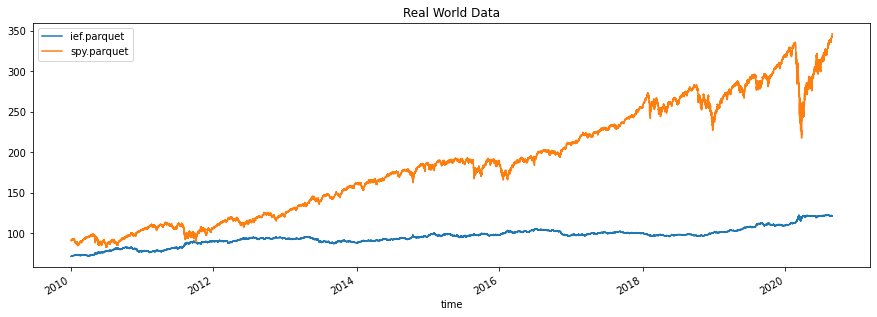

In [2]:
env=DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters=meta_parameters,
                                                                     data_hash="real_wordl_test",
                                                                     objective_parameters=objective_parameters)
env.assets_prices.plot(figsize=(15,5),title="Real World Data"),

(<AxesSubplot:title={'center':'Simulated Data'}>,)

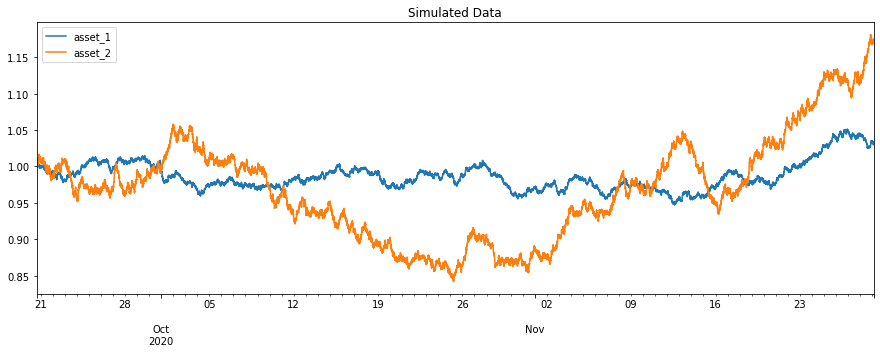

In [3]:

assets_simulation_details={"asset_1":{"method":"GBM","sigma":.1,"mean":.1},
                    "asset_2":{"method":"GBM","sigma":.2,"mean":.2}}

env_2=DeepTradingEnvironment.build_environment_from_simulated_assets(assets_simulation_details=assets_simulation_details,data_hash="simulation_gbm",
                                                                     meta_parameters=meta_parameters,objective_parameters=objective_parameters)

env_2.assets_prices.plot(figsize=(15,5),title="Simulated Data"),

## What we want?

We want to build an automated "Agent" that behaves as a portfolio manager. 

## What do we need?

We need to shape this data into a Reinforcement Learning Framework to train our Agent

1. We need to define an  environment that holds all the available data for training or testing.
2. **We need to define an  state that holds the previous decisions of the agent ( the weights of the portfolio), provides to the agent with the information at this time and the change of state given an action
3. We need to define an agent that takes actiona on the data provided. 





## What does this means from data perspective?

### State Data

All the algorithms that we will try optimize the decisions of the agent given an state. 

So to transform our data in to states we have the following parameters:

* in_bars_count: number of bars that will constitute our state. (if our frequency is 1 minute and in_bars_count=30, then we will use information from the last 30 minutes)
* out_reward_window : the time frame that we will use  as measurement  after an action 
* feature_map: an historical set of features that will feed the model according to "in_bars_count"

Lets look at an example (in this case we are assuming our features are log_returns)
```
meta_parameters = {"in_bars_count": 30,
                   "out_reward_window": datetime.timedelta(minutes=10),
                   "state_type":"in_window_out_window"}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001}

```

In [17]:

date=env.assets_prices.index[100]
state_features, weights_on_date =env.state.get_state_on_date(target_date=date)
print("on date {} we observe {} input features".format(date,state_features.shape))
state_features.head()


on date 2010-01-05 16:25:00+00:00 we observe (30, 2) input features


,ief.parquet,spy.parquet
time,,
2010-01-04 20:30:00+00:00,0.000338,-0.000618
2010-01-04 20:35:00+00:00,0.000676,0.000442
2010-01-04 20:40:00+00:00,0.000450,0.001148
2010-01-04 20:45:00+00:00,0.000338,0.000000
2010-01-04 20:50:00+00:00,0.002698,0.000177


In [10]:
state_features.tail()

,ief.parquet,spy.parquet
time,,
2010-01-05 16:05:00+00:00,0.000449,-0.001057
2010-01-05 16:10:00+00:00,0.000337,-0.001498
2010-01-05 16:15:00+00:00,0.000224,-0.000970
2010-01-05 16:20:00+00:00,0.000560,-0.000794
2010-01-05 16:25:00+00:00,0.000224,-0.000706


In [18]:
print("and the weights that the portfolio have up to that time")
weights_on_date.head()

and the weights that the portfolio have up to that time


ief.parquet    0.5
spy.parquet    0.5
Name: 2010-01-05 16:25:00+00:00, dtype: float64

Whenever we take an action (Agent chooses portfolio weights) we get a reward equivalent to the out return



In [25]:
action_portfolio_weights = np.random.rand(2)
obs, reward, done, info = env.step(action_portfolio_weights=action_portfolio_weights,
                                                action_date=date)
reward

time
2010-01-05 16:25:00+00:00    0.000011
dtype: float64

Under this setup , our data from a Reinfrocement Learning Perspective of $s_t,a,r,s_\text{t_out}$'

**S_t**

* dimension: [(in_bars_window,number_of_features) ,(1,number_of_assets)] <br>
* information: features up to time "t" and weights up to time "t"

** a **
* dimension: (number_of_assets,) <br>
* information: weights on time t

** r **
* dimension: (1) 
* information: returns from time "t" to "t+_out"

** S_tout **

* dimension: [(in_bars_window,number_of_features) ,(1,number_of_assets)] <br>
* information: features up to time "t_out" and weights up to time "t_out"



**SHOULD THIS BE IN THIS PREENTATION BETTER FOR NEXT ONE?**

One dimension continuos action

$$
\pi(a|s,\theta)=\frac{1}{\sigma(s,\theta)\sqrt{2\pi}}exp(-\frac{(a-\mu(s,\theta))^2}{2\sigma(s,\theta)})
$$

We parametrize mu as we pleased. Simples parametrization

$$
\mu(s,\theta)=\theta_{\mu}^Tx(s)
$$

$$
\sigma(s,\theta)=exp(\theta_{\sigma}^Tx(s))
$$

Now 

$$
\theta=[\theta_{\mu},\theta_{\sigma}]
$$


Initialize variance to be large to have explorations